# Task 1
## Statistical Learning with Deep Artificial Neural Networks
###  Violeta Basten Romero, Giovanni Dal Mas, Ian Wallgren



In this task, on the basis of the mobile specification like Battery power, 3G enabled , wifi , Bluetooth, Ram, etc, we aim to predict the price range of the mobile. \

In this dataset,
columns are:


- battery_power: Total energy a battery can store in one time measured in mAh
- blue: Has bluetooth or not
- clock_speed: speed at which microprocessor executes instructions
- dual_sim: Has dual sim support or not
- fc: Front Camera mega pixels
- four_g: Has 4G or not
- int_memory: Internal Memory in Gigabytes
- m_dep: Mobile Depth in cm
- mobile_wt: Weight of mobile phone
- n_cores: Number of cores of processor
- pc :Primary Camera mega pixels
- px_height: Pixel Resolution Height
- px_width: Pixel Resolution Width
- ram: Random Access Memory in Megabytes
- sc_h: Screen Height of mobile in cm
- sc_w: Screen Width of mobile in cm
- talk_time: longest time that a single battery charge will last when you are
- three_g: Has 3G or not
- touch_screen: Has touch screen or not
- wifi: Has wifi or not

The response variable
- price_range: With value of 0(low cost), 1(medium cost), 2(high cost) and (very high cost).

##0. Loading libraries and data

In [1]:
import pandas as pd

import numpy as np
from numpy import loadtxt

import random

import cufflinks as cf
cf.go_offline()

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,f1_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.layers import Dense, Input, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/mobile.csv'
data = pd.read_csv(path, sep = ';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. Describe mobile dataset. How many observations? How many and what variable types ? Are there missing data?

We begin by checking data quality and try to familiarize ourselves with the data set

In [3]:
def check_missing_data(df,col=int):
  n = len(df)
  #we don't need to specify how to drop NaNs since we are only looking at one col, doing it for good habits
  missing_data = n - len(df.iloc[:,col].dropna(how='all'))
  return missing_data

columns       = [i for i in range(0,data.shape[1])]
missing_data  = pd.DataFrame([check_missing_data(data,x) for x in columns]).set_index(data.columns)
missing_data

,0
battery_power,0
blue,0
clock_speed,0
dual_sim,0
fc,0
four_g,0
int_memory,0
m_dep,0
mobile_wt,0
n_cores,0


It seems like there is no missing data


In the data set we have 2000 observations, and 22 variables for each of these. There are binary variables(blue, dual_sim, four_g, three_g, touch_screen, wifi), integer (battery_power, fc, int_memory, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, talk_time), and continuous variables (clock_speed, m_dep, mobile_wt). There is also a categorical variables such as the response variable "price range", assuming values in a certain interval ∈ Ζ, assigning each observation to a particular group.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Let's have a look at the column values

In [5]:
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Clearly, the variables need to be normalized in order for us to be able to compare them with eachother. We use the MinMaxScaler.

In [6]:
#Normalization
scaler = MinMaxScaler()

mobile = pd.DataFrame(scaler.fit_transform(data),
            columns=data.columns, index=data.index)

mobile.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0.227789,0.0,0.68,0.0,0.052632,0.0,0.080645,0.555556,0.900000,0.142857,...,0.010204,0.170895,0.612774,0.285714,0.388889,0.944444,0.0,0.0,1.0,0.333333
1,0.347361,1.0,0.00,1.0,0.000000,1.0,0.822581,0.666667,0.466667,0.285714,...,0.461735,0.993324,0.634687,0.857143,0.166667,0.277778,1.0,1.0,0.0,0.666667
2,0.041416,1.0,0.00,1.0,0.105263,1.0,0.629032,0.888889,0.541667,0.571429,...,0.644388,0.811749,0.627205,0.428571,0.111111,0.388889,1.0,1.0,0.0,0.666667
3,0.076152,1.0,0.80,0.0,0.000000,0.0,0.129032,0.777778,0.425000,0.714286,...,0.620408,0.858478,0.671566,0.785714,0.444444,0.500000,1.0,0.0,0.0,0.666667
4,0.881764,1.0,0.28,0.0,0.684211,1.0,0.677419,0.555556,0.508333,0.142857,...,0.616327,0.475300,0.308658,0.214286,0.111111,0.722222,1.0,1.0,0.0,0.333333


Better.

##2. Split the dataset in 2/3 of training and 1/3 of test.

We proceed to split the dataset in train and test set

In [7]:
X = mobile.drop(columns='price_range')
y = mobile[['price_range']]

#Split the data
X_train, X_test_1, y_train, y_test_1 = train_test_split(X, y, test_size=1/3, random_state=42)

We perform an additional split to create a validation set from the test set, in order to use it to tune our hyperparameters n (nodes) and d (amount of callback). We use the 30% of the test set.

In [8]:
#Split the data
X_test, X_val, y_test, y_val = train_test_split(X_test_1, y_test_1, test_size=0.3, random_state=42)

##3. Taking only the numerical variables, fit a dense neural network (DNN) to predict the price_range.
We define the DNN with a single hidden layer with n nodes and d amount of dropout.

In [9]:
# Separate data
# Numerical variables
num_vars = ['battery_power','clock_speed','fc','int_memory','m_dep','mobile_wt','n_cores','pc',
            'px_height','px_width','ram','sc_h','sc_w', 'talk_time']
X_train_numerical = X_train[num_vars]
X_val_numerical = X_val[num_vars]
X_test_numerical = X_test[num_vars]

In [10]:
# Convert the training, validation and testing data to numpy arrays
X_train_numerical = X_train_numerical.values.astype(float)
X_val_numerical = X_val_numerical.values.astype(float)
X_test_numerical = X_test_numerical.values.astype(float)

y_train = y_train.values.astype(float)
y_val = y_val.values.astype(float)
y_test = y_test.values.astype(float)

# Convert the response variable to categorical data
y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_val = keras.utils.to_categorical(y_val, num_classes=4)
y_test= keras.utils.to_categorical(y_test, num_classes=4)

We define a DNN_model function in order to perform faster the hyperparameter tuning

In [11]:
random.seed(42)
# It contains the length of the input shape to the first layer below
input_shape_n = len(num_vars)

# Define a function DNN_model to build and train the DNN with a single hidden layer
def DNN_model(n, d):
    model = Sequential()
    model.add(Dense(n, input_shape=(input_shape_n,), activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(4,activation='sigmoid'))

    #now we compile our model
    #since we have a multiple different classes in our response variable, we choose categorical crossentropy as our loss function
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    #fit model
    #verbose = 0 no output of progress (3/4 of the pdf would be just this)
    model_fitted = model.fit(x=X_train_numerical,y=y_train,
          batch_size=64,
          epochs=50,
          validation_data=(X_val_numerical, y_val),
          verbose=0)

    validation_accuracy = model_fitted.history['val_accuracy'][-1]

    return (validation_accuracy, model_fitted)



Hyperparameter tuning using Random Search. We also set a seed to reproducibility.

In [12]:
random.seed(42)
# Perform hyperparameter tuning using random search
n_values = [5, 8, 10] # Possible values of n
d_values = [0.2, 0.4] # Possible values of d
num_samples = 20 # Number of random hyperparameter combinations to try
results = [] # List to store the validation accuracy for each set of hyperparameters
for i in range(num_samples):
    # Randomly select values of n and d
    n = np.random.choice(n_values)
    d = np.random.choice(d_values)
    # Train the model with the selected hyperparameters and get the validation accuracy
    val_acc = DNN_model(n, d)[0]
    # Store the hyperparameters and validation accuracy in the results list
    results.append({'n': n, 'd': d, 'val_acc': val_acc})

# Print the results in descending order of validation accuracy
results_df = pd.DataFrame(results) # Convert the results list to a pandas dataframe
results_df = results_df.sort_values('val_acc', ascending=False) # Sort the dataframe by validation accuracy
print(results_df) # Print the results dataframe

     n    d   val_acc
12   8  0.2  0.935323
15  10  0.2  0.930348
10  10  0.2  0.910448
3    8  0.4  0.910448
7    8  0.2  0.905473
11   8  0.2  0.880597
17  10  0.4  0.875622
16  10  0.4  0.875622
5    8  0.2  0.870647
8   10  0.4  0.870647
1   10  0.4  0.870647
9    5  0.2  0.865672
0   10  0.4  0.855721
4   10  0.4  0.850746
19   8  0.2  0.850746
2    8  0.2  0.845771
18   5  0.4  0.840796
13   5  0.2  0.820895
14   8  0.4  0.820895
6    5  0.2  0.820895


The best model turns out to be the one with n = 8 and d = 0.2, with 93,53% accuracy

##5. Using the best model and the test set provide performance metrics.

In the previous part we used the validation set to tune our hyperparameters and find the best model. Now that we know that the best model has 8 nodes and amount of callback equal to 0.2, this time we use the test set, in order to have unseen data ad a more fair prediction.

In [13]:
random.seed(42)
# best model
best_model = Sequential()
best_model.add(Dense(8, input_shape=(input_shape_n,), activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(4,activation='sigmoid'))

# compile model
best_model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#fit model
model_history = best_model.fit(x=X_train_numerical,y=y_train,
          batch_size=64,
          epochs=50,
          validation_data=(X_test_numerical, y_test),
          verbose=0)

print(best_model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 8)                 120       
                                                                 
 dropout_20 (Dropout)        (None, 8)                 0         
                                                                 
 dense_41 (Dense)            (None, 4)                 36        
                                                                 
Total params: 156
Trainable params: 156
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
best_model.evaluate(X_train_numerical, y_train)

42/42 [==============================] - 0s 2ms/step - loss: 0.3405 - accuracy: 0.8395


[0.3404565751552582, 0.8394598364830017]

In [19]:
best_model.evaluate(X_test_numerical, y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.3713 - accuracy: 0.8176


[0.37127095460891724, 0.8175965547561646]

This DNN model achieved a training accuracy of 83.95% and a test accuracy of 81.76%. The losses are respectively 0.3405 and 0.3713.

We define a function to plot the loss and accuracy

In [20]:
# function to plot the loss and accuracy
def plot_loss_accuracy(model_history):
    # Create subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle("Training Metrics")

    # Plot the training and validation loss
    ax1.plot(model_history.history['loss'], label='Training Loss')
    ax1.plot(model_history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the training and validation accuracy
    ax2.plot(model_history.history['accuracy'], label='Training Accuracy')
    ax2.plot(model_history.history['val_accuracy'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()


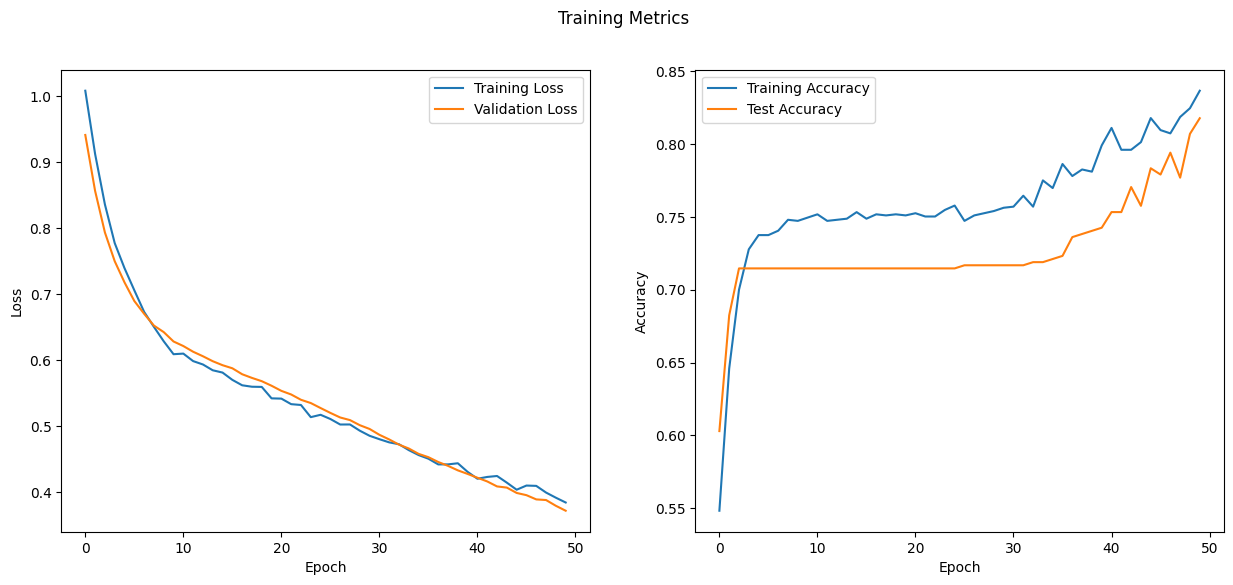

In [21]:
plot_loss_accuracy(model_history)

##6. Taking only the binary variables, implement an autoencoder (AE). Provide evidences of the quality of the coding obtained.

In [22]:
random.seed(42)
# Binary variables
bin_vars = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
X_train_binary = X_train[bin_vars]
X_test_binary = X_test[bin_vars]


# Define encoder
inputs = Input(shape=(len(bin_vars),))
x = Dense(16, activation='relu')(inputs)
x = Dense(8, activation='relu')(x)
latent = Dense(4, activation='relu')(x)
encoder = Model(inputs, latent, name='encoder')

# Define decoder
x = Dense(8, activation='relu')(latent)
x = Dense(16, activation='relu')(x)
outputs = Dense(len(bin_vars), activation='sigmoid')(x)
decoder = Model(latent, outputs, name='decoder')

# Define autoencoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

# Compile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train model
autoencoder.fit(X_train_binary, X_train_binary, epochs=50, batch_size=64,
                validation_data=(X_test_binary, X_test_binary))


Epoch 1/50
21/21 [==============================] - 3s 13ms/step - loss: 0.6866 - val_loss: 0.6815
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 0.6787 - val_loss: 0.6706
Epoch 3/50
21/21 [==============================] - 0s 6ms/step - loss: 0.6670 - val_loss: 0.6552
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.6496 - val_loss: 0.6331
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 0.6246 - val_loss: 0.6057
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 0.6007 - val_loss: 0.5844
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.5819 - val_loss: 0.5677
Epoch 8/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5668 - val_loss: 0.5539
Epoch 9/50
21/21 [==============================] - 0s 6ms/step - loss: 0.5534 - val_loss: 0.5407
Epoch 10/50
21/21 [==============================] - 0s 6ms/step - loss: 0.5390 - val_loss: 0.5260
Epoch 11/50
21/21 

##7. Extract the latent descriptors of train and test set, corresponding to the binary variables.

In [23]:
# Extracting latent descriptors for binary variables
train_latent_binary = encoder.predict(X_train_binary)
test_latent_binary = encoder.predict(X_test_binary)

15/15 [==============================] - 0s 1ms/step


##8. Build and fit a DNN to predict the price_range that integrates the numerical variables and the latent descriptors for binary variables you found in (7).

In [24]:
len(num_vars)

14

In [25]:
random.seed(42)
# define the input layers
numerical_input = Input(shape=(len(num_vars),))
binary_input = Input(shape=(len(bin_vars),))

# Hidden layers for numerical input
num_hidden = Dense(64, activation='relu')(numerical_input)
num_hidden = Dense(32, activation='relu')(num_hidden)

# Hidden layers for binary input
bin_hidden = Dense(32, activation='relu')(binary_input)
bin_hidden = Dense(16, activation='relu')(bin_hidden)

# concatenate the numerical and binary hidden layers
concat = Concatenate()([num_hidden, bin_hidden])

# define the output layer
output = Dense(4, activation='softmax')(concat)

# define the model
num_lat_model = Model(inputs=[numerical_input, binary_input], outputs=output)

# compile the model
num_lat_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fit the model
num_lat_model_history = num_lat_model.fit([X_train_numerical, X_train_binary], y_train, epochs=50, batch_size=64, validation_data=([X_test_numerical, X_test_binary], y_test))

print(num_lat_model.summary())

Epoch 1/50
21/21 [==============================] - 2s 21ms/step - loss: 1.2445 - accuracy: 0.4741 - val_loss: 0.9657 - val_accuracy: 0.7146
Epoch 2/50
21/21 [==============================] - 0s 10ms/step - loss: 0.7501 - accuracy: 0.7517 - val_loss: 0.6623 - val_accuracy: 0.7146
Epoch 3/50
21/21 [==============================] - 0s 9ms/step - loss: 0.5558 - accuracy: 0.7509 - val_loss: 0.5481 - val_accuracy: 0.7167
Epoch 4/50
21/21 [==============================] - 0s 11ms/step - loss: 0.4810 - accuracy: 0.7599 - val_loss: 0.4816 - val_accuracy: 0.7597
Epoch 5/50
21/21 [==============================] - 0s 10ms/step - loss: 0.4195 - accuracy: 0.8065 - val_loss: 0.4154 - val_accuracy: 0.8391
Epoch 6/50
21/21 [==============================] - 0s 10ms/step - loss: 0.3627 - accuracy: 0.8605 - val_loss: 0.3592 - val_accuracy: 0.8627
Epoch 7/50
21/21 [==============================] - 0s 11ms/step - loss: 0.3143 - accuracy: 0.8965 - val_loss: 0.3171 - val_accuracy: 0.8734
Epoch 8/50
21/

In [26]:
num_lat_model.evaluate([X_train_numerical, X_train_binary], y_train)

42/42 [==============================] - 0s 3ms/step - loss: 0.0388 - accuracy: 0.9962


[0.03875736892223358, 0.9962490797042847]

In [27]:
num_lat_model.evaluate([X_test_numerical, X_test_binary], y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.9742


[0.06568760424852371, 0.9742489457130432]

The new DNN model that integrates numerical variables and the latent descriptors of the binary ones reaches a training accuracy of 99.62% and a test accuracy of 97.42%. The improvement on the train and test loss is also notable with respectively 0.039 and 0.066.

##9. Using the test set provide performance metrics.

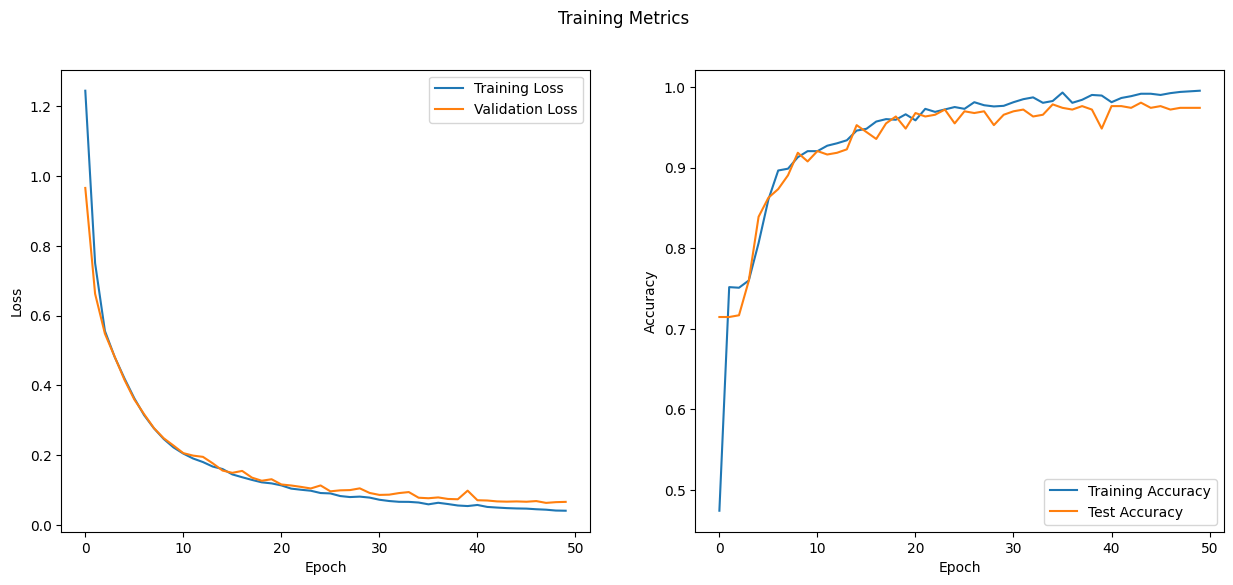

In [28]:
plot_loss_accuracy(num_lat_model_history)

##10. Discuss the results of the analysis.

In this analysis, we aimed to predict the price range of mobile phones using a combination of numerical and binary variables. We split the dataset into 2/3 for training and 1/3 for testing, and additionally took a 30% of the testing set as validation test for the hypertuning. We trained a dense neural network using only the numerical variables. Through hyperparameter tuning, we found that a DNN with a single hidden layer with 8 nodes and a dropout of 0.2 yielded the best results. This DNN model achieved a training accuracy of 83.95% and a test accuracy of 81.76%. The losses were respectively 0.3405 and 0.3713.

Next, we implemented an autoencoder using only the binary variables. We extracted the latent descriptors of the train and test sets corresponding to the binary variables. We used these latent descriptors and the numerical variables to build and fit a second DNN model to predict the price range. This model achieved a training loss of 0.0388 and a training accuracy of 99.62%, while the validation loss was 0.0657 and the test accuracy was 97.42%.

Overall, our analysis shows that combining both numerical and binary variables can significantly improve the accuracy of predicting the price range of mobile phones. The use of an autoencoder to extract the latent descriptors of binary variables proved to be effective, and the combination of these descriptors with numerical variables led to a highly accurate model for predicting price range.